In [1]:
from __future__ import annotations

from typing import  List
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: C:\Users\markm\Documents\programming\Flexible-Cloud-Resource\analysis


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from docplex.cp.model import CpoModel, CpoVariable, SOLVE_STATUS_FEASIBLE, SOLVE_STATUS_OPTIMAL

from src.core.core import server_task_allocation
from src.extra.io import ImageFormat, save_plot
from src.core.core import reset_model
from src.core.fixed_task import FixedTask, SumSpeedsFixedPolicy
from src.core.server import Server
from src.core.task import Task
from src.greedy.greedy import greedy_algorithm
from src.greedy.resource_allocation_policy import SumPowPercentage
from src.greedy.server_selection_policy import ProductResources
from src.greedy.value_density import UtilityDeadlinePerResource
from src.optimal.fixed_optimal import fixed_optimal
from src.optimal.flexible_optimal import flexible_optimal

In [3]:
matplotlib.rcParams['font.family'] = 'monospace'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
matplotlib.rc('font', weight='bold')

c:\users\markm\anaconda3\envs\flexible-cloud-resource\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### Model Setting

In [4]:
tasks = [
    Task("Task 1",  required_storage=100, required_computation=100, required_results_data=50, deadline=10, value=100),
    Task("Task 2",  required_storage=75,  required_computation=125, required_results_data=40, deadline=10, value=90),
    Task("Task 3",  required_storage=125, required_computation=110, required_results_data=45, deadline=10, value=110),
    Task("Task 4",  required_storage=100, required_computation=75,  required_results_data=60, deadline=10, value=75),
    Task("Task 5",  required_storage=85,  required_computation=90,  required_results_data=55, deadline=10, value=125),
    Task("Task 6",  required_storage=75,  required_computation=120, required_results_data=40, deadline=10, value=100),
    Task("Task 7",  required_storage=125, required_computation=100, required_results_data=50, deadline=10, value=80),
    Task("Task 8",  required_storage=115, required_computation=75,  required_results_data=55, deadline=10, value=110),
    Task("Task 9",  required_storage=100, required_computation=110, required_results_data=60, deadline=10, value=120),
    Task("Task 10", required_storage=90,  required_computation=120, required_results_data=40, deadline=10, value=90),
    Task("Task 11", required_storage=110, required_computation=90,  required_results_data=45, deadline=10, value=100),
    Task("Task 12", required_storage=100, required_computation=80,  required_results_data=55, deadline=10, value=100)
]

servers = [
    Server("Server 1", storage_capacity=500, computation_capacity=95, bandwidth_capacity=220),
    Server("Server 2", storage_capacity=500, computation_capacity=95, bandwidth_capacity=210),
    Server("Server 3", storage_capacity=500, computation_capacity=90, bandwidth_capacity=250)
]

In [5]:
def print_tasks(tasks: List[Task]):
    print(f'Social welfare: {sum(task.value for task in tasks if task.running_server)}, '
          f'percentage tasks allocated: {sum(task.running_server is not None for task in tasks)}')
    max_task_name_len = max(len(task.name) for task in tasks) + 1
    print("{:<{}}| Value |{:^9}|{:^13}|{:^9}|{:^10}|{:^9}|{:^9}|{:^9}| {}"
          .format("Name", max_task_name_len, "Storage", "Computation", "Results", "Deadline", 
                  "Loading", "Compute", "Sending", "Server"))
    
    for task in tasks:
        print("{:<{name_len}}|{:^7.1f}|{:^9}|{:^13}|{:^9}|{:^10}|{:^9}|{:^9}|{:^9}|{:^10}"
              .format(task.name, task.value, task.required_storage, task.required_computation, task.required_results_data,
                      task.deadline, task.loading_speed, task.compute_speed, task.sending_speed,
                      task.running_server.name if task.running_server else "None", name_len=max_task_name_len))

### Plot allocation results

In [6]:
def plot_allocation_results(tasks: List[Task], servers: List[Server], title: str, large_txt: int = 14, small_txt: int = 13,
                            image_formats: Iterable[ImageFormat] = (ImageFormat.PNG,)):
    """
    Plots the allocation results

    :param tasks: List of tasks
    :param servers: List of servers
    :param title: The title
    :param image_formats: The save image format list
    """

    allocated_tasks = [task for task in tasks if task.running_server]
    loading_df = pd.DataFrame(
        [[task.required_storage / server.storage_capacity if task.running_server == server else 0
          for task in allocated_tasks] for server in servers],
        index=[server.name for server in servers], columns=[task.name for task in allocated_tasks])
    compute_df = pd.DataFrame(
        [[task.compute_speed / server.computation_capacity if task.running_server == server else 0
          for task in allocated_tasks] for server in servers],
        index=[server.name for server in servers], columns=[task.name for task in allocated_tasks])
    sending_df = pd.DataFrame(
        [[(task.loading_speed + task.sending_speed) / server.bandwidth_capacity if task.running_server == server else 0
          for task in allocated_tasks] for server in servers],
        index=[server.name for server in servers], columns=[task.name for task in allocated_tasks])
    resources_df = [loading_df, compute_df, sending_df]

    n_col, n_ind = len(resources_df[0].columns), len(resources_df[0].index)
    hatching = '\\'

    fig, axe = plt.subplots(figsize=(7, 4))
    for resource_df in resources_df:  # for each data frame
        axe = resource_df.plot(kind='bar', linewidth=0, stacked=True, ax=axe, legend=False, grid=False)

    h, _l = axe.get_legend_handles_labels()  # get the handles we want to modify
    for i in range(0, 3 * n_col, n_col):
        for j, pa in enumerate(h[i:i + n_col]):
            for rect in pa.patches:
                rect.set_x(rect.get_x() + 1 / float(3 + 1) * i / float(n_col) - 0.125)
                rect.set_hatch(hatching * int(i / n_col))
                rect.set_width(1 / float(3 + 1))

    axe.set_xlabel(r'\textbf{Servers}', fontsize=large_txt)
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(3 + 1)) / 2. - 0.125)
    axe.set_xticklabels(resources_df[0].index, rotation=0, fontsize=small_txt)

    axe.set_ylabel(r'\textbf{Resource Usage}', fontsize=large_txt)
    axe.set_ylim((0.0, 1.0))
    axe.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axe.set_yticklabels([r'0\%', r'20\%', r'40\%', r'60\%', r'80\%', r'100\%'], fontsize=small_txt)

    # axe.set_title(title, fontsize=16)

    pos = 1 - 0.0625 * sum(task.running_server is not None for task in tasks) - 0.08
    server_resources_legend = [axe.bar(0, 0, color="gray", hatch=hatching * i) for i in range(3)]
    tasks_legend = axe.legend(h[:n_col], _l[:n_col], loc=[1.025, pos], title=r'Tasks')  # 0.17
    plt.legend(server_resources_legend, ['Storage', 'Computation', 'Bandwidth'],
               loc=[1.025, pos - 0.29], title=r'Server resources')  # -0.12
    axe.add_artist(tasks_legend)

    plt.tight_layout()

    save_plot(title.lower().replace(' ', '_'), 'example_allocation', image_formats=image_formats)
    plt.show()

### Minimise flexible resource allocation

In [7]:
def minimise_resource_allocation(tasks: List[Task], servers: List[Server], time_limit: int = 1):
    """
    Minimise resource allocation of a list of servers

    :param tasks: List of new tasks to the server (this is important for the online flexible case)
    :param servers: List of servers
    :param time_limit: Solve time limit
    """
    for server in servers:
        server_new_tasks = [task for task in server.allocated_tasks if task in tasks]
        model = CpoModel('MinimumAllocation')

        loading_speeds: Dict[Task, CpoVariable] = {}
        compute_speeds: Dict[Task, CpoVariable] = {}
        sending_speeds: Dict[Task, CpoVariable] = {}

        # The maximum bandwidth and the computation that the speed can be
        max_bandwidth = sum(task.loading_speed + task.sending_speed for task in server_new_tasks)
        max_computation = sum(task.compute_speed for task in server_new_tasks)

        # Loop over each task to allocate the variables and add the deadline constraints
        for task in server_new_tasks:
            loading_speeds[task] = model.integer_var(min=1, max=max_bandwidth)
            compute_speeds[task] = model.integer_var(min=1, max=max_computation)
            sending_speeds[task] = model.integer_var(min=1, max=max_bandwidth)

            model.add((task.required_storage / loading_speeds[task]) +
                      (task.required_computation / compute_speeds[task]) +
                      (task.required_results_data / sending_speeds[task]) <= task.deadline)

        model.add(sum(compute_speeds[task] for task in server_new_tasks) <= max_computation)
        model.add(sum(loading_speeds[task] + sending_speeds[task] for task in server_new_tasks) <= max_bandwidth)

        model.minimize(
            (sum(loading_speeds[task] + sending_speeds[task] for task in server_new_tasks) / max_bandwidth) ** 3 +
            (sum(compute_speeds[task] for task in server_new_tasks) / max_computation) ** 3)

        model_solution = model.solve(log_output=None, TimeLimit=time_limit)

        # Check that it is solved
        if model_solution.get_solve_status() != SOLVE_STATUS_FEASIBLE and \
                model_solution.get_solve_status() != SOLVE_STATUS_OPTIMAL:
            print(f'Minimise {server.name} server resources allocated failed: {model_solution.get_solve_status()}')
            continue

        allocated_tasks = server.allocated_tasks.copy()
        server.reset_allocations()
        for task in allocated_tasks:
            if task in server_new_tasks:
                task.reset_allocation()
                server_task_allocation(server, task,
                                       model_solution.get_value(loading_speeds[task]),
                                       model_solution.get_value(compute_speeds[task]),
                                       model_solution.get_value(sending_speeds[task]))
            else:
                server.allocate_task(task)

### Optimal Solution

Minimise Server 1 server resources allocated failed: Unknown
Social welfare: 1200, percentage tasks allocated: 12
Name    | Value | Storage | Computation | Results | Deadline | Loading | Compute | Sending | Server
Task 1  | 100.0 |   100   |     100     |   50    |    10    |   34    |   22    |   20    | Server 2 
Task 2  | 90.0  |   75    |     125     |   40    |    10    |   17    |   36    |   20    | Server 1 
Task 3  | 110.0 |   125   |     110     |   45    |    10    |   40    |   22    |   24    | Server 3 
Task 4  | 75.0  |   100   |     75      |   60    |    10    |   33    |   23    |   17    | Server 1 
Task 5  | 125.0 |   85    |     90      |   55    |    10    |   43    |   16    |   24    | Server 1 
Task 6  | 100.0 |   75    |     120     |   40    |    10    |   26    |   24    |   19    | Server 2 
Task 7  | 80.0  |   125   |     100     |   50    |    10    |   41    |   21    |   23    | Server 3 
Task 8  | 110.0 |   115   |     75      |   55    |    10    |   

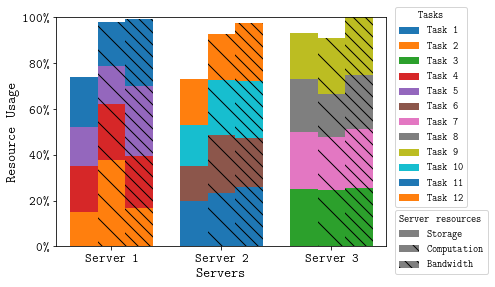

In [8]:
optimal_results = flexible_optimal(tasks, servers, time_limit=5)
minimise_resource_allocation(tasks, servers)

print_tasks(tasks)
plot_allocation_results(tasks, servers, "Optimal Flexible Resource Allocation")
reset_model(tasks, servers)

### Fixed Solution

Social welfare: 955, percentage tasks allocated: 9
Name    | Value | Storage | Computation | Results | Deadline | Loading | Compute | Sending | Server
Task 1  | 100.0 |   100   |     100     |   50    |    10    |   24    |   30    |   20    | Server 1 
Task 2  | 90.0  |   75    |     125     |   40    |    10    |   23    |   27    |   19    |   None   
Task 3  | 110.0 |   125   |     110     |   45    |    10    |   35    |   28    |   18    | Server 1 
Task 4  | 75.0  |   100   |     75      |   60    |    10    |   25    |   25    |   20    |   None   
Task 5  | 125.0 |   85    |     90      |   55    |    10    |   21    |   27    |   21    | Server 3 
Task 6  | 100.0 |   75    |     120     |   40    |    10    |   20    |   29    |   19    | Server 2 
Task 7  | 80.0  |   125   |     100     |   50    |    10    |   33    |   28    |   19    |   None   
Task 8  | 110.0 |   115   |     75      |   55    |    10    |   30    |   22    |   20    | Server 2 
Task 9  | 120.0 |   100  

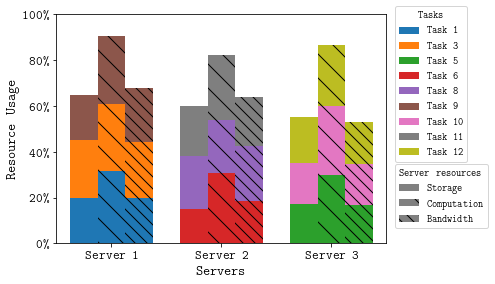

In [9]:
fixed_tasks = [FixedTask(task, SumSpeedsFixedPolicy(), fixed_name=False) for task in tasks]
fixed_results = fixed_optimal(fixed_tasks, servers, time_limit=5)

print_tasks(fixed_tasks)
plot_allocation_results(fixed_tasks, servers, "Optimal Fixed Resource Allocation")
reset_model(tasks, servers)

### Greedy Solution

Social welfare: 1200, percentage tasks allocated: 12
Name    | Value | Storage | Computation | Results | Deadline | Loading | Compute | Sending | Server
Task 1  | 100.0 |   100   |     100     |   50    |    10    |   32    |   23    |   20    | Server 1 
Task 2  | 90.0  |   75    |     125     |   40    |    10    |   30    |   22    |   22    | Server 3 
Task 3  | 110.0 |   125   |     110     |   45    |    10    |   33    |   26    |   23    | Server 1 
Task 4  | 75.0  |   100   |     75      |   60    |    10    |   30    |   18    |   24    | Server 3 
Task 5  | 125.0 |   85    |     90      |   55    |    10    |   26    |   21    |   23    | Server 2 
Task 6  | 100.0 |   75    |     120     |   40    |    10    |   25    |   24    |   20    | Server 2 
Task 7  | 80.0  |   125   |     100     |   50    |    10    |   42    |   20    |   25    | Server 3 
Task 8  | 110.0 |   115   |     75      |   55    |    10    |   32    |   20    |   21    | Server 2 
Task 9  | 120.0 |   100

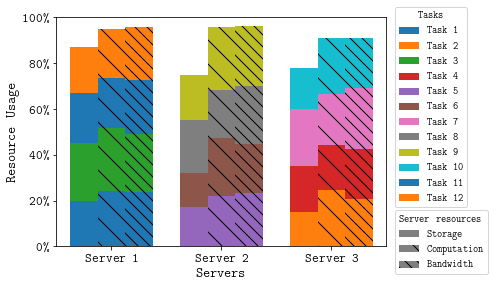

In [10]:
greedy_results = greedy_algorithm(tasks, servers, UtilityDeadlinePerResource(), ProductResources(), SumPowPercentage())

print_tasks(tasks)
plot_allocation_results(tasks, servers, "Greedy Flexible Resource Allocation")
reset_model(tasks, servers)

### Optimal, Fixed and Greedy results

In [11]:
"""results = {'Optimal': optimal_results, 'Fixed': fixed_results, 'Greedy': greedy_results}

max_name_len = max(len(name) for name in results.keys())
max_storage_len = max(len(str(list(result.server_storage_used.values()))) for result in results.values())
max_computation_len = max(len(str(list(result.server_computation_used.values()))) for result in results.values())
max_bandwidth_len = max(len(str(list(result.server_bandwidth_used.values()))) for result in results.values())

print(f"{'Name':<{max_name_len}} | Social Welfare | {'Storage':^{max_storage_len}} | {'Computation':^{max_computation_len}} | "
      f"{'Bandwidth':^{max_bandwidth_len}} | Num Jobs")
for name, result in results.items():
    print(f"{name:<{max_name_len}} | {result.social_welfare:^5} | "
          f"{str(list(result.server_storage_used.values())):^{max_storage_len}} | "
          f"{str(list(result.server_computation_used.values())):^{max_computation_len}} | "
          f"{str(list(result.server_bandwidth_used.values())):^{max_bandwidth_len}} | "
          f"{str(list(result.server_num_tasks_allocated.values()))}")"""

'results = {\'Optimal\': optimal_results, \'Fixed\': fixed_results, \'Greedy\': greedy_results}\n\nmax_name_len = max(len(name) for name in results.keys())\nmax_storage_len = max(len(str(list(result.server_storage_used.values()))) for result in results.values())\nmax_computation_len = max(len(str(list(result.server_computation_used.values()))) for result in results.values())\nmax_bandwidth_len = max(len(str(list(result.server_bandwidth_used.values()))) for result in results.values())\n\nprint(f"{\'Name\':<{max_name_len}} | Social Welfare | {\'Storage\':^{max_storage_len}} | {\'Computation\':^{max_computation_len}} | "\n      f"{\'Bandwidth\':^{max_bandwidth_len}} | Num Jobs")\nfor name, result in results.items():\n    print(f"{name:<{max_name_len}} | {result.social_welfare:^5} | "\n          f"{str(list(result.server_storage_used.values())):^{max_storage_len}} | "\n          f"{str(list(result.server_computation_used.values())):^{max_computation_len}} | "\n          f"{str(list(result.

## Model to latex converter

In [12]:
for task in fixed_tasks:
    print(f'{task.name} & {task.value} & {task.required_storage} & {task.required_computation} & '
          f'{task.required_results_data} & {task.deadline} & {task.loading_speed} & {task.compute_speed} & '
          f'{task.sending_speed} \\\\ \\hline')
print('')
for server in servers:    
    print(f'{server.name} & {server.storage_capacity} & {server.computation_capacity} & {server.bandwidth_capacity} \\\\ \\hline')

Task 1 & 100 & 100 & 100 & 50 & 10 & 24 & 30 & 20 \\ \hline
Task 2 & 90 & 75 & 125 & 40 & 10 & 23 & 27 & 19 \\ \hline
Task 3 & 110 & 125 & 110 & 45 & 10 & 35 & 28 & 18 \\ \hline
Task 4 & 75 & 100 & 75 & 60 & 10 & 25 & 25 & 20 \\ \hline
Task 5 & 125 & 85 & 90 & 55 & 10 & 21 & 27 & 21 \\ \hline
Task 6 & 100 & 75 & 120 & 40 & 10 & 20 & 29 & 19 \\ \hline
Task 7 & 80 & 125 & 100 & 50 & 10 & 33 & 28 & 19 \\ \hline
Task 8 & 110 & 115 & 75 & 55 & 10 & 30 & 22 & 20 \\ \hline
Task 9 & 120 & 100 & 110 & 60 & 10 & 30 & 28 & 22 \\ \hline
Task 10 & 90 & 90 & 120 & 40 & 10 & 27 & 27 & 18 \\ \hline
Task 11 & 100 & 110 & 90 & 45 & 10 & 25 & 27 & 20 \\ \hline
Task 12 & 100 & 100 & 80 & 55 & 10 & 24 & 24 & 22 \\ \hline

Server 1 & 500 & 95 & 220 \\ \hline
Server 2 & 500 & 95 & 210 \\ \hline
Server 3 & 500 & 90 & 250 \\ \hline
